In [56]:
import torch

# 1. CUDA 사용 가능 여부 확인
print(f"CUDA Available: {torch.cuda.is_available()}")

# 2. 사용 가능한 GPU 개수
print(f"GPU Count: {torch.cuda.device_count()}")

# 3. 현재 GPU 이름 (RTX 4060이 나와야 함)
if torch.cuda.is_available():
    print(f"GPU Name: {torch.cuda.get_device_name(0)}")

# 4. 장치 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

CUDA Available: True
GPU Count: 1
GPU Name: NVIDIA GeForce RTX 4060
Using device: cuda


In [57]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

In [58]:
# 장치 설정 (기존 코드에 빠져있던 부분 추가)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# 1. 전처리 정의: 변수명을 모듈명(transforms)과 다르게 설정하여 충돌 방지
mnist_transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

In [59]:
# 데이터셋 로드
train_dataset = datasets.MNIST(root='./data', train=True, transform=mnist_transform, download=True)
test_dataset = datasets.MNIST(root='./data', train=False, transform=mnist_transform, download=True)

train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)

In [60]:
# 2. 모델 정의
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool = nn.MaxPool2d(2, 2)
        # 64*5*5는 (28x28)이 Conv-Pool을 두 번 거치며 줄어든 최종 피처맵 크기입니다.
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        # Activation 함수를 torch.relu()로 호출 (방법 1)
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(x.size(0), -1) 
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [61]:
# 모델 객체 생성 
model = CNN().to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [62]:
# 3. 학습 함수
def train(model, device, train_loader, optimizer, loss_fn):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    avg_loss = running_loss / len(train_loader)
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [63]:
# 4. 평가 함수
def evaluate(model, device, test_loader, loss_fn):
    model.eval()
    running_loss, correct, total = 0.0, 0, 0
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
    return running_loss / len(test_loader), 100 * correct / total

In [64]:
# 5. 실행 루프 (Epoch 100은 매우 길 수 있으므로 테스트 시에는 5-10회 권장)
num_epochs = 100
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []
best_test_accuracy = 0.0

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, device, train_loader, optimizer, loss_fn)
    test_loss, test_acc = evaluate(model, device, test_loader, loss_fn)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    # 최고 정확도 모델 저장
    if test_acc > best_test_accuracy:
        best_test_accuracy = test_acc
        torch.save(model.state_dict(), 'best_mnist_cnn.pth')
        print(f"Epoch {epoch+1}: New best accuracy {test_acc:.2f}% - Model Saved")

Epoch 1: New best accuracy 98.29% - Model Saved
Epoch 2: New best accuracy 98.93% - Model Saved
Epoch 3: New best accuracy 99.02% - Model Saved
Epoch 4: New best accuracy 99.18% - Model Saved
Epoch 11: New best accuracy 99.21% - Model Saved
Epoch 12: New best accuracy 99.30% - Model Saved
Epoch 61: New best accuracy 99.34% - Model Saved
Epoch 68: New best accuracy 99.35% - Model Saved
Epoch 72: New best accuracy 99.37% - Model Saved


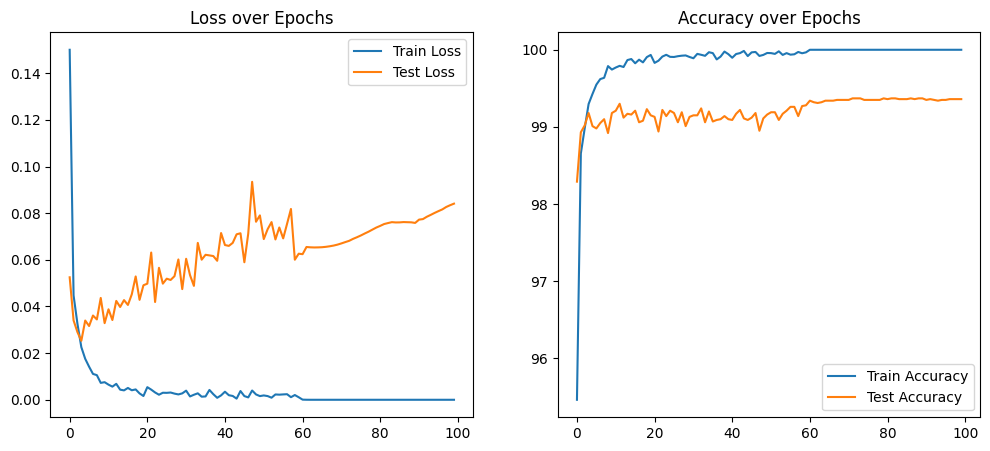

<module 'matplotlib.pyplot' from 'c:\\lab\\vision\\lib\\site-packages\\matplotlib\\pyplot.py'>

In [65]:
# 시각화 (plt.Figure -> plt.figure)
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt

In [66]:
# 6. 추론 (Inference)
def preprocess_image(image_path):
    image = Image.open(image_path).convert('L')
    image = np.array(image)
    # MNIST는 배경이 검고 글씨가 흰색이므로, 일반 손글씨(흰 배경)라면 반전이 필요합니다.
    image = Image.fromarray(255 - image) 
    
    inf_transform = transforms.Compose([
        transforms.Resize((28, 28)), # 튜플 형식으로 수정
        transforms.ToTensor(), 
        transforms.Normalize((0.5,), (0.5,))
    ])
    return inf_transform(image).unsqueeze(0)

# 모델 재로드 및 테스트
infer_model = CNN().to(device)
infer_model.load_state_dict(torch.load('best_mnist_cnn.pth'))
infer_model.eval()

CNN(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1600, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [67]:
# sam.png 파일이 있다고 가정
try:
    image_path = 'sam.png'
    input_tensor = preprocess_image(image_path).to(device)
    with torch.no_grad():
        output = infer_model(input_tensor)
        _, predicted = torch.max(output, 1)
        print(f'추론 결과: {predicted.item()}')
except FileNotFoundError:
    print("파일을 찾을 수 없습니다. 경로를 확인하세요.")


추론 결과: 3
